# **BIG DATA ANALYSIS**

In [ ]:
!pip install pyspark


In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Reviews Analysis") \
    .getOrCreate()


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Reviews Analysis") \
    .getOrCreate()


In [ ]:
df = spark.read.csv("Reviews.csv", header=True, inferSchema=True)


In [ ]:
from pyspark.sql.functions import col, count, avg, desc

# Convert Score to numeric type
df = df.withColumn("Score", col("Score").cast("double"))

# Schema
df.printSchema()

# First 5 rows
df.show(5)

# Total rows
print("Total rows:", df.count())

# Missing values
df.select([count(col(c)).alias(c) for c in df.columns]).show()

# Average score
df.groupBy().avg("Score").show()

# Top 10 most reviewed products
df.groupBy("ProductId") \
  .agg(count("*").alias("review_count")) \
  .orderBy(desc("review_count")) \
  .show(10)

# Top 10 reviewers
df.groupBy("UserId") \
  .agg(count("*").alias("review_count")) \
  .orderBy(desc("review_count")) \
  .show(10)

# Rating distribution
df.groupBy("Score").count().orderBy("Score").show()


root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|  5.0|1303862400|Go

In [ ]:

spark.stop()



# **PREDICTIVE ANALYSIS**

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
df = df.withColumn("label", when(col("Score") >= 4, 1).otherwise(0))
df = df.select("Text", "label").na.drop()


In [ ]:
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2000)
idf = IDF(inputCol="rawFeatures", outputCol="features")


In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)


In [ ]:
predictions = model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.83


In [ ]:
model.save("reviews_model")


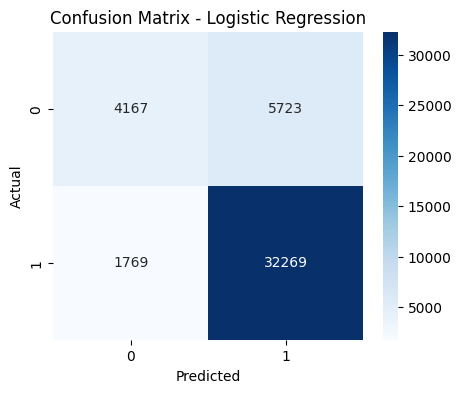

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


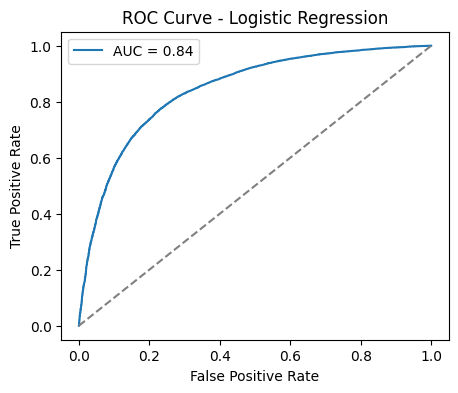

In [ ]:
from sklearn.metrics import roc_curve, auc

# Extract probability of positive class
preds_pd["prob_pos"] = preds_pd["probability"].apply(lambda x: float(x[1]))
fpr, tpr, thresholds = roc_curve(preds_pd["label"], preds_pd["prob_pos"])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


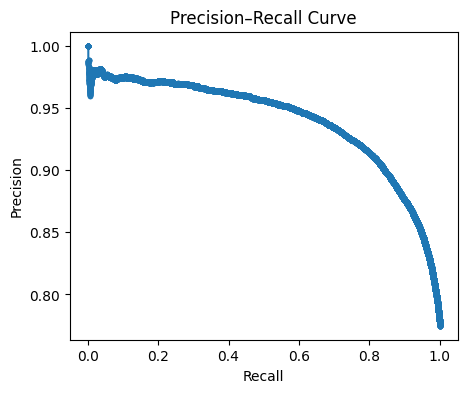

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(preds_pd["label"], preds_pd["prob_pos"])
plt.figure(figsize=(5,4))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification metrics
print(classification_report(preds_pd["label"], preds_pd["prediction"]))


              precision    recall  f1-score   support

           0       0.70      0.42      0.53      9890
           1       0.85      0.95      0.90     34038

    accuracy                           0.83     43928
   macro avg       0.78      0.68      0.71     43928
weighted avg       0.82      0.83      0.81     43928



# **DASHBOARD**


In [ ]:
!pip install streamlit plotly pyngrok -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
%%writefile dashboard.py
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

# Load predictions (assuming you've saved preds_pd.csv earlier)
preds_pd = pd.read_csv("preds_pd.csv")

st.title("📊 Logistic Regression Model Dashboard")

# Confusion Matrix
st.subheader("Confusion Matrix")
cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])
fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=["Predicted 0", "Predicted 1"],
    y=["Actual 0", "Actual 1"],
    colorscale="Blues"
)
st.plotly_chart(fig_cm)

# ROC Curve
st.subheader("ROC Curve")
preds_pd["prob_pos"] = preds_pd["probability"].apply(lambda x: float(x.strip("[]").split(",")[1]))
fpr, tpr, _ = roc_curve(preds_pd["label"], preds_pd["prob_pos"])
roc_auc = auc(fpr, tpr)
fig_roc = px.area(
    x=fpr, y=tpr,
    title=f"ROC Curve (AUC={roc_auc:.2f})",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=500, height=400
)
fig_roc.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
st.plotly_chart(fig_roc)

# Precision-Recall Curve
st.subheader("Precision–Recall Curve")
precision, recall, _ = precision_recall_curve(preds_pd["label"], preds_pd["prob_pos"])
fig_pr = px.line(
    x=recall, y=precision,
    labels=dict(x="Recall", y="Precision"),
    title="Precision–Recall Curve"
)
st.plotly_chart(fig_pr)

# Classification Report
st.subheader("Classification Report")
report = classification_report(preds_pd["label"], preds_pd["prediction"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
st.dataframe(report_df)


Writing dashboard.py


In [ ]:
# Mount Drive (so you don't re-upload every time)
from google.colab import drive
drive.mount('/content/drive')

# EDIT THIS PATH if your file is elsewhere in Drive
gdrive_path = "/content/drive/MyDrive/Reviews.csv"  # <-- change if needed

import os
if not os.path.exists(gdrive_path):
    raise FileNotFoundError(f"Couldn't find Reviews.csv at {gdrive_path}. Put the file there or change the path.")
print("Found Reviews.csv at:", gdrive_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found Reviews.csv at: /content/drive/MyDrive/Reviews.csv


In [ ]:

# Start a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("ReviewsClassification") \
    .config("spark.driver.memory","4g") \
    .getOrCreate()

# Load CSV from Drive
df = spark.read.csv(gdrive_path, header=True, inferSchema=True)
print("Rows:", df.count())
df.show(5)
df.printSchema()


Rows: 568454
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl

In [ ]:
from pyspark.sql.functions import when, col

# Create binary label: positive if Score >= 4, else negative
if 'Score' not in df.columns:
    raise ValueError("No 'Score' column found. Edit dataset or code.")

df = df.withColumn("label", when(col("Score") >= 4, 1).otherwise(0))

# Try typical text column names
possible_text_cols = [c for c in df.columns if c.lower() in ('text','review','reviewtext','review_text','reviewbody','reviewbodystring')]
if not possible_text_cols:
    # fallback: choose a string column with long average length
    string_cols = [c for c, t in df.dtypes if t == 'string']
    chosen = None
    for c in string_cols:
        avg_len = df.selectExpr(f"avg(length({c})) as avg_len").collect()[0]['avg_len']
        if avg_len and avg_len > 20:
            chosen = c
            break
    if not chosen:
        raise ValueError("Couldn't auto-detect a text column. Rename your review text column to 'Text' or similar.")
    text_col = chosen
else:
    text_col = possible_text_cols[0]

print("Using text column:", text_col)

# Keep only required cols and drop null texts
df = df.select(col(text_col).alias("text"), col("label")).na.drop(subset=["text"])
df.show(5)


Using text column: Text
+--------------------+-----+
|                text|label|
+--------------------+-----+
|I have bought sev...|    1|
|"Product arrived ...|    0|
|"This is a confec...|    1|
|If you are lookin...|    0|
|Great taffy at a ...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Pipeline stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Train/test split and fit
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())

model = pipeline.fit(train_df)
predictions = model.transform(test_df).cache()
predictions.select("text", "label", "prediction", "probability").show(5, truncate=100)


Train rows: 454646 Test rows: 113798
+----------------------------------------+-----+----------+----------------------------------------+
|                                    text|label|prediction|                             probability|
+----------------------------------------+-----+----------+----------------------------------------+
| But the ""Sea Salt"" Chips Taste Funky"|    0|       1.0| [0.4992322074680543,0.5007677925319457]|
|                                   Grape|    1|       1.0| [0.2695604384465564,0.7304395615534436]|
|                  He's a Big Boy Now!"""|    1|       1.0|[0.20346341227352185,0.7965365877264782]|
|                               Mommy!"""|    1|       1.0|[0.15929592562931158,0.8407040743706884]|
|                                Stand Up|    1|       1.0|[0.26830994843649025,0.7316900515635097]|
+----------------------------------------+-----+----------+----------------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator_acc.evaluate(predictions)
print(f"Accuracy = {acc:.4f}")

# AUC (Binary)
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"AUC = {auc:.4f}")

# Confusion matrix (collect to driver)
pred_pd = predictions.select("label", "prediction", "probability").toPandas()
# add prob_pos numeric column
pred_pd['prob_pos'] = pred_pd['probability'].apply(lambda v: float(v[1]))
print(pred_pd[['label','prediction','prob_pos']].head())


Accuracy = 0.8805
AUC = 0.9106
   label  prediction  prob_pos
0      0         1.0  0.500768
1      1         1.0  0.730440
2      1         1.0  0.796537
3      1         1.0  0.840704
4      1         1.0  0.731690


In [ ]:
# Save preds to CSV (Streamlit will read this)
preds_path = "/content/preds_pd.csv"
pred_pd.to_csv(preds_path, index=False)
print("Saved predictions to", preds_path)


Saved predictions to /content/preds_pd.csv


In [ ]:
%%writefile dashboard.py
import streamlit as st
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import plotly.figure_factory as ff

st.set_page_config(page_title="Logistic Regression Dashboard", layout="centered")

st.title("📊 Logistic Regression Results Dashboard")

# Load preds
preds = pd.read_csv("preds_pd.csv")
st.markdown("### Dataset preview")
st.dataframe(preds.head(200))

# Confusion Matrix
st.markdown("### Confusion Matrix")
cm = confusion_matrix(preds["label"], preds["prediction"])
fig_cm = ff.create_annotated_heatmap(
    z=cm.tolist(),
    x=["Predicted 0", "Predicted 1"],
    y=["Actual 0", "Actual 1"],
    colorscale="Blues"
)
fig_cm.update_layout(width=600, height=450)
st.plotly_chart(fig_cm)

# ROC Curve
st.markdown("### ROC Curve & AUC")
fpr, tpr, _ = roc_curve(preds["label"], preds["prob_pos"])
roc_auc = auc(fpr, tpr)
fig_roc = px.area(x=fpr, y=tpr, title=f"ROC Curve (AUC={roc_auc:.3f})",
                  labels=dict(x="False Positive Rate", y="True Positive Rate"))
fig_roc.add_shape(type="line", x0=0, x1=1, y0=0, y1=1, line=dict(dash="dash"))
st.plotly_chart(fig_roc)

# Precision-Recall
st.markdown("### Precision–Recall Curve")
precision, recall, _ = precision_recall_curve(preds["label"], preds["prob_pos"])
fig_pr = px.line(x=recall, y=precision, labels=dict(x="Recall", y="Precision"), title="Precision–Recall Curve")
st.plotly_chart(fig_pr)

# Classification report
st.markdown("### Classification Report")
report = classification_report(preds["label"], preds["prediction"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
st.dataframe(report_df)


Writing dashboard.py


In [ ]:
!ngrok config add-authtoken YOUR_AUTHTOKEN_HERE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok config add-authtoken cr_313lvbfEmVBaxNRTjePU9i12sRp


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Install and set up ngrok
!pip install pyngrok --quiet

# 🔹 Add your ngrok Authtoken here
# Get it from https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTH_TOKEN = "313muduGjMFFYVTlGuuFmPnMvlS_2Q8vTEwMYcGhMS5hTceQx"

# Configure ngrok with your token
!ngrok config add-authtoken $NGROK_AUTH_TOKEN

from pyngrok import ngrok

# Start HTTP tunnel for the dashboard
public_url = ngrok.connect(8050)
print("Public Dashboard URL:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


Public Dashboard URL: NgrokTunnel: "https://fa35c00a038d.ngrok-free.app" -> "http://localhost:8050"


# **#SENTIMENTAL ANALYSIS**

In [ ]:
#INSTALL AND IMPORT PYSPARK
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
#START SPARK AND LOAD DATA
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Change path to your actual file location
df = spark.read.csv("/content/Reviews.csv", header=True, inferSchema=True)

df.show(5)


+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

In [ ]:
#PREPARE SENTIMENT LABELS
df = df.withColumn("label", when(col("Score") >= 4, "positive")
                                 .when(col("Score") <= 2, "negative")
                                 .otherwise("neutral"))

df = df.filter(df.label != "neutral")  # Remove neutral for binary classification
df.show(5)


+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+--------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|   label|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+--------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|positive|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|negative|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|positive|
|  4|B000U

In [ ]:
#PREPROCESSING
# Tokenize
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
df = tokenizer.transform(df)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Convert to numerical features (TF-IDF)
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)


In [ ]:
#ENCODE LABELS
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
df = indexer.fit(df).transform(df)


In [ ]:
#TRAIN AND TEST SPLIT
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
#TRAIN LOGISTIC REGRESSION MODEL
lr = LogisticRegression(featuresCol="features", labelCol="labelIndex")
lr_model = lr.fit(train_df)


In [ ]:
#PREDICTIONS AND EVALUATION
predictions = lr_model.transform(test_df)
predictions.select("Text", "label", "prediction").show(10, truncate=False)

evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+----------+
|Text                                                                                                                                                                                                 